**Part 1**

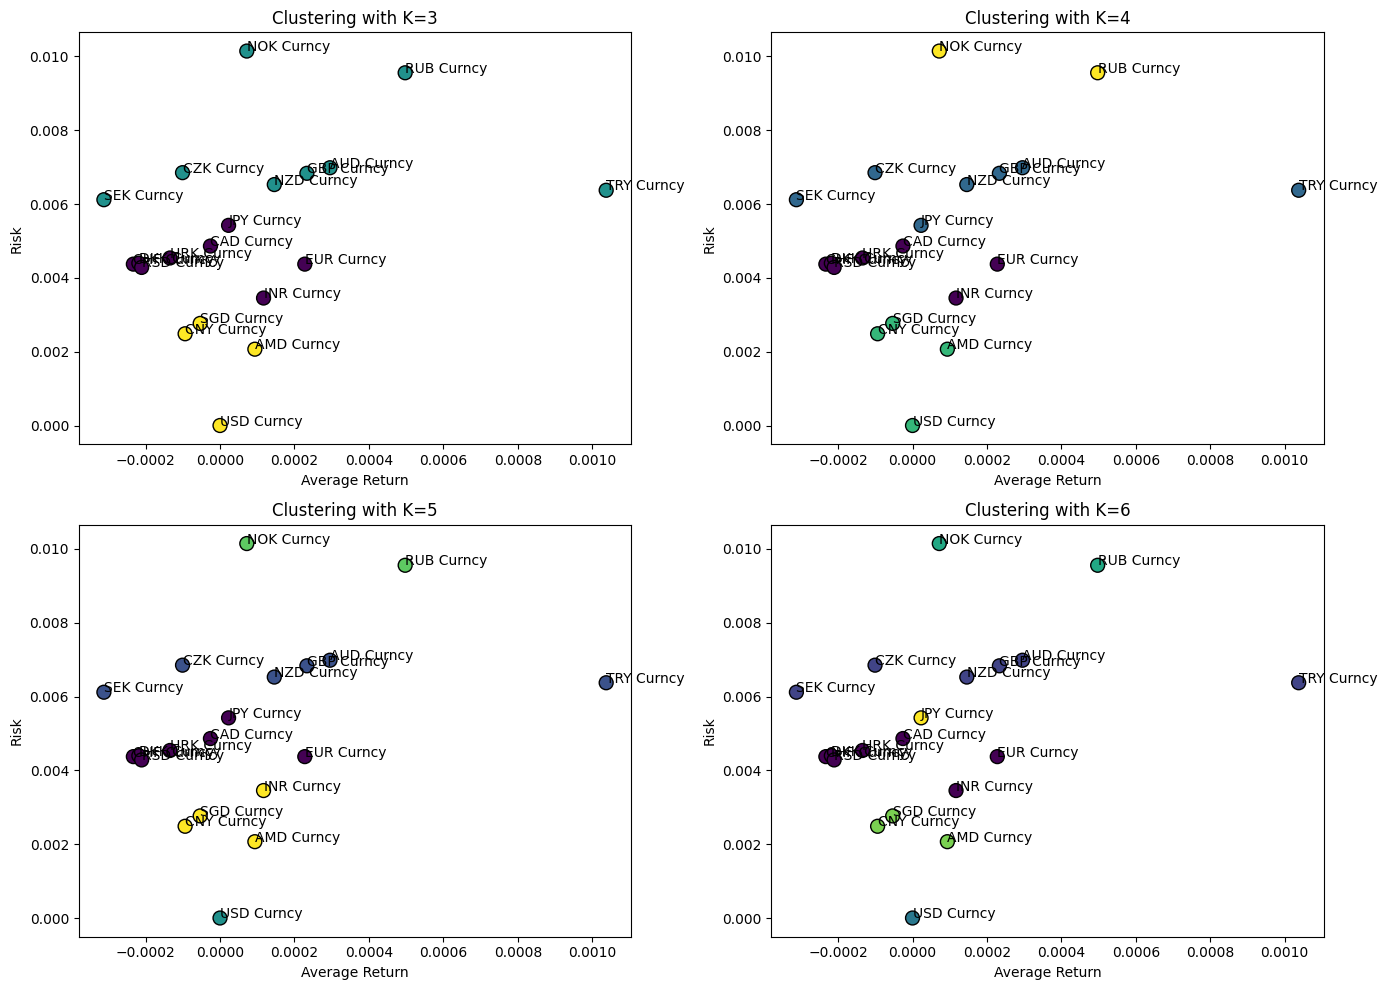

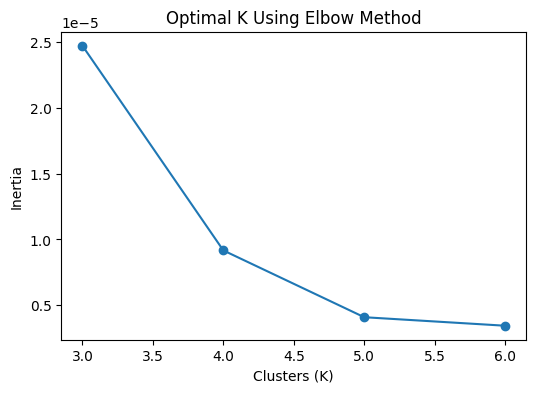

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

data = pd.read_excel('Currencies_1yr.xlsx')
data.index = pd.to_datetime(data.index)
data.set_index(data.columns[0], inplace=True)

returns = data.pct_change().dropna()

summary = pd.DataFrame({
    'avg_return': returns.mean(),
    'risk': returns.std()
})

cluster_range = [3, 4, 5, 6]
inertia = {}
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, k in enumerate(cluster_range):
    model = KMeans(n_clusters=k, random_state=42)
    clusters = model.fit_predict(summary)
    inertia[k] = model.inertia_

    axes[i].scatter(summary['avg_return'], summary['risk'],
                    c=clusters, cmap='viridis', s=100, edgecolor='k')

    for j, name in enumerate(summary.index):
        axes[i].annotate(name, (summary['avg_return'].iloc[j], summary['risk'].iloc[j]))

    axes[i].set_title(f'Clustering with K={k}')
    axes[i].set_xlabel('Average Return')
    axes[i].set_ylabel('Risk')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o')
plt.title('Optimal K Using Elbow Method')
plt.xlabel('Clusters (K)')
plt.ylabel('Inertia')
plt.show()



# Each cluster represents currencies with similar risk-return profiles, where higher clusters typically contain currencies with either higher volatility, higher returns, or distinctive combinations of both characteristics compared to more stable baseline currencies.

**Part 2**

In [15]:
# Ledoit-Wolf and OAS shrinkage methods improve covariance matrix estimation by reducing noise and stabilizing the matrix, especially in cases with high condition numbers. These techniques shrink the sample covariance towards a more stable estimate.

import numpy as np
from sklearn.covariance import OAS, LedoitWolf

np.random.seed(42)
original_data = np.random.normal(size=(1000, 20))

noise_factor = 1e-4 * np.random.normal(size=(1000, 2))
modified_data = original_data.copy()
modified_data[:, -2:] = np.tile(original_data[:, 0].reshape(-1, 1), (1, 2)) + noise_factor

cov_original = np.cov(original_data, rowvar=False)
cov_modified = np.cov(modified_data, rowvar=False)

cond_original = np.linalg.cond(cov_original)
cond_modified = np.linalg.cond(cov_modified)

print(f"Condition number of original covariance: {cond_original:.2f}")
print(f"Condition number of modified covariance: {cond_modified:.2f}")

oas_model = OAS().fit(modified_data)
oas_covariance = oas_model.covariance_
cond_oas = np.linalg.cond(oas_covariance)
print(f"Condition number after OAS shrinkage: {cond_oas:.2f}")

# Applying Ledoit-Wolf shrinkage
lw_model = LedoitWolf().fit(modified_data)
lw_covariance = lw_model.covariance_
cond_lw = np.linalg.cond(lw_covariance)

print(f"Condition number after Ledoit-Wolf shrinkage: {cond_cov_lw:.2f}")


# Ledoit-Wolf uses an analytically optimal shrinkage parameter, while OAS iteratively approximates the oracle estimator for potentially better performance.




Condition number of original covariance: 1.64
Condition number of modified covariance: 894395561.03
Condition number after OAS shrinkage: 45.86
Condition number after Ledoit-Wolf shrinkage: 45.63


**Part 3**

Condition number of the covariance matrix: 6084.01
Condition number after applying OAS shrinkage: 1089.17


<ipython-input-16-62478e6fbfef>:23: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_linkage = linkage(distance_matrix, method='single')


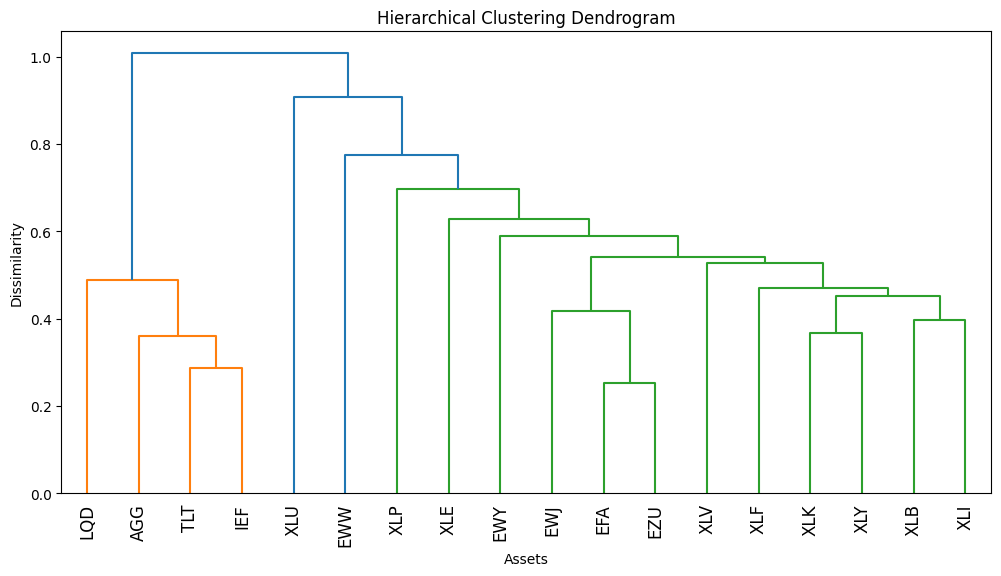

<ipython-input-16-62478e6fbfef>:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.91519065 0.91519065 0.91519065 0.91519065 0.91519065 0.91519065
 0.91519065 0.91519065 0.91519065]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_weights[cluster_a] *= alpha


Optimal Portfolio Weights (HRP Allocation):
AGG    0.451945
EFA    0.010979
EWJ    0.009217
EWW    0.004611
EWY    0.003147
EZU    0.006288
IEF    0.181500
LQD    0.189148
TLT    0.043983
XLB    0.013810
XLE    0.010297
XLF    0.012233
XLI    0.007270
XLK    0.005005
XLP    0.016514
XLU    0.015160
XLV    0.010285
XLY    0.008609
dtype: float64


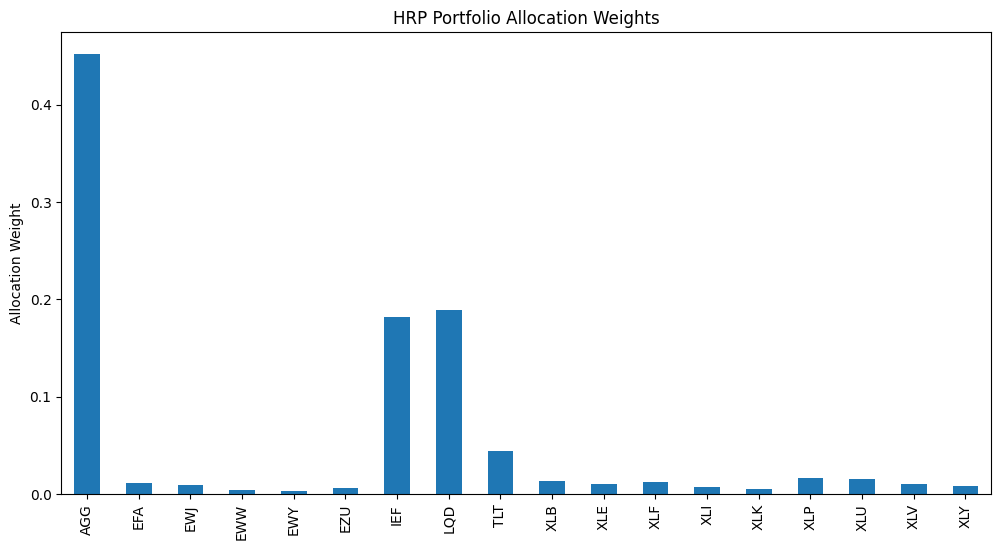

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.covariance import OAS

price_data = pd.read_csv('index_prices.csv', index_col=0)
price_data.index = pd.to_datetime(price_data.index)

price_returns = price_data.pct_change().dropna()

cov_matrix = price_returns.cov()
cov_condition_number = np.linalg.cond(cov_matrix)
print(f"Condition number of the covariance matrix: {cov_condition_number:.2f}")

oas_estimator = OAS().fit(price_returns)
shrunk_cov_matrix = pd.DataFrame(oas_estimator.covariance_, index=price_returns.columns, columns=price_returns.columns)
shrunk_cov_condition_number = np.linalg.cond(shrunk_cov_matrix)
print(f"Condition number after applying OAS shrinkage: {shrunk_cov_condition_number:.2f}")

correlation_matrix = price_returns.corr()
distance_matrix = np.sqrt(0.5 * (1 - correlation_matrix))
cluster_linkage = linkage(distance_matrix, method='single')

plt.figure(figsize=(12, 6))
dendrogram(cluster_linkage, labels=price_returns.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Assets')
plt.ylabel('Dissimilarity')
plt.show()

ivp_weights = 1. / np.diag(shrunk_cov_matrix)
ivp_weights /= ivp_weights.sum()

portfolio_weights = pd.Series(1, index=price_returns.columns)
asset_clusters = [price_returns.columns]

while asset_clusters:
    next_clusters = []
    for cluster in asset_clusters:
        if len(cluster) == 1:
            continue
        mid = len(cluster) // 2
        cluster_a, cluster_b = cluster[:mid], cluster[mid:]

        sub_cov_a = shrunk_cov_matrix.loc[cluster_a, cluster_a]
        ivp_a = 1. / np.diag(sub_cov_a)
        ivp_a /= ivp_a.sum()
        var_a = np.dot(ivp_a, np.dot(sub_cov_a, ivp_a))

        sub_cov_b = shrunk_cov_matrix.loc[cluster_b, cluster_b]
        ivp_b = 1. / np.diag(sub_cov_b)
        ivp_b /= ivp_b.sum()
        var_b = np.dot(ivp_b, np.dot(sub_cov_b, ivp_b))

        alpha = 1 - var_a / (var_a + var_b)
        portfolio_weights[cluster_a] *= alpha
        portfolio_weights[cluster_b] *= (1 - alpha)
        next_clusters += [cluster_a, cluster_b]
    asset_clusters = next_clusters

portfolio_weights = portfolio_weights.sort_index()
print("Optimal Portfolio Weights (HRP Allocation):")
print(portfolio_weights)

plt.figure(figsize=(12, 6))
portfolio_weights.plot(kind='bar', title='HRP Portfolio Allocation Weights')
plt.ylabel('Allocation Weight')
plt.show()
